# Klassifikation mit PyTorch

Dieses vierte und letzte Notebook nutzt PyTorch um Neuronale Netze zu entwickeln, welche professionelle Spieler von unprofessionellen trennt. Dazu wird zuerst ein `Torch Dataset` und anschließend ein `PyTorch-Lightning DataModule` erstellt. Dieses kann dann vom `PyTorch-Lightning Module` über den Trainer konsumiert werden. `PyTorch-Lightning` ist ein Wrapper um schnell Neuronale Netze zu implementieren und diese mit diversen Methoden zu trainieren.

In [2]:
import time
from typing import List
import logging

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
import torchmetrics
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import seaborn as sns

## Das Dataset

Das Dataset basiert auf dem im zweiten Notebook erzeugtem Datensatz in Form eines DataFrames. Aus diesem wird bei der Erstellung des Datasets zuerst für die beiden kategorischen Features `Map` und `Region` ein Label-Encoder implementiert. Darauf werden die encodierten Kategorien zusammen mit den ohnehin schon numerischen Werten zu Numpy-Arrays extrahiert, damit diese später in PyTorch-Tensoren transformiert werden können. Wie in dem letzten Notebook werden lediglich die Attribute `["Region", "Map", "K/R Ratio", "K/D Ratio", "Premade", "Kills", "MVPs", "Headshots", "Triple Kills"]` extrahiert. Das PyTorch-Lightning Data Module implementiert den Train/Validate/Test-Split mit einer 81/9/10 Ratio. Weiterhin implementiert das Data Module auch den PyTorch DataLoader, welcher die Daten des Datensatzes in Batches einteilt und diese zu Torch-Tensoren umwandelt. Die Trainingsdaten werden dabei zufällig gebatched, die Validierungs- und Testdaten um Vergleichbarkeit beizubehalten nicht zufällig. Um die Daten schneller zu laden werden 12 Worker benutzt, wodurch 11 Batches schon vor Benutzung auf anderen Threads geladen werden.

In [2]:
class CsgoProfessionalDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        region_map = {k:v for v, k in enumerate(df["Region"].unique())}
        map_map = {k:v for v, k in enumerate(df["Map"].unique())}
        self.x = np.array([
            np.array([region_map[x] for x in df["Region"]]),
            np.array([map_map[x] for x in df["Map"]]),
            df["K/R Ratio"].to_numpy(),
            df["K/D Ratio"].to_numpy(),
            df["Premade"].to_numpy(),
            df["Kills"].to_numpy(),
            df["MVPs"].to_numpy(),
            df["Headshots"].to_numpy(),
            df["Triple Kills"].to_numpy()
        ], dtype=np.float32)
        self.y = df["Professional"].to_numpy(np.float32)

    def __getitem__(self, idx):
        return self.x[:, idx], self.y[idx]

    def __len__(self):
        return len(self.y)

class CsgoProfessionalDataModule(pl.LightningDataModule):
    def __init__(self, df: pd.DataFrame, batch_size=32):
        super().__init__()
        self.df = df
        self.batch_size = batch_size

    def setup(self, stage = None):
        fit_test_split = int(len(self.df) * 0.9)
        if stage == "fit" or stage is None:
            ds_full = CsgoProfessionalDataset(self.df[:fit_test_split])
            train_len = int(fit_test_split * 0.9)
            val_len = fit_test_split - train_len
            self.ds_train, self.ds_val = random_split(ds_full, [train_len, val_len])

        if stage == "test" or stage is None:
            self.ds_test = CsgoProfessionalDataset(self.df[fit_test_split:])

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, drop_last=True, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size, drop_last=True, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size, drop_last=True, num_workers=12)

## Das Modell

Das PyTorch-Lightning Module implementiert das neuronale Netz sowie die Trainings-Loop. Allgemein wird sich an sämtliche Standards für die Implementierung von PyTorch Modellen mit PyTorch-Lightning gehalten, um so viele Funktionen von Lightning wie möglich nutzen zu können und die Code-Base entsprechend klein, einfach und verständlich zu halten. Dazu ist natürlich entsprechendes Vorwissen über die Funktionsweise des PyTorch-Lightning Frameworks vorausgesetzt. Das Netz hat folgenden Aufbau:

- `9` Input-Nodes
- `9xN` Gewichte
-> `N` Hidden-Nodes
- ReLU Aktivierungsfunktion
- Dropout
-> `N` Hidden-Nodes
- `NxN` Gewichte
-> `N` Hidden-Nodes
- ReLU Aktivierungsfunktion
- Dropout
-> `N` Hidden-Nodes
- `Nx1` Gewichte
-> `1` Node
- Sigmoid
- Threshold `0.5`
-> Ergebnis

Die Auswahl dieser Architektur geschah willkürlich basierend auf Erfahrung und Ausprobieren.

In der Trainigns-Loop wird der `Binary-Cross-Entropy-With-Logits` Verlust berechnet, entsprechend ohne Anwendung der Sigmoid Funktion. Diese ist mathematisch in die Verlustfunktion integriert und muss deshalb nur bei der Inferenz angewendet werden. Das Training optimiert über den Adam-Optimierungsalgorithmus. Zur Validierung wird die Bibliothek `torchmetrics` genutzt, welche die schon im 3. Notebook genutzten Metriken Accuracy, F1Score, Precision und Recall implementiert und auf PyTorch-Lightning besonders angepasst ist.

In [3]:
class CsgoProfessionalClassifier(pl.LightningModule):

    def __init__(self, learning_rate: float, hidden_layers: int, dropout: float, loss_weight: float=0.5):
        super().__init__()
        self.learning_rate = learning_rate
        self.layers = nn.Sequential(
            nn.Linear(9, hidden_layers),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_layers, hidden_layers),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_layers, 1)
        )
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(loss_weight))
        self.sigmoid = nn.Sigmoid()
        self.metrics = torchmetrics.MetricCollection([
            #torchmetrics.AUC(),
            torchmetrics.Accuracy(),
            torchmetrics.F1Score(),
            torchmetrics.Precision(),
            torchmetrics.Recall()
        ])

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        x = x.squeeze()
        return x

    def training_step(self, batch: List[torch.Tensor], batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: List[torch.Tensor], batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log("val_loss", loss)
        preds = self.sigmoid(logits)
        self.metrics(preds, y.int())
        self.log_dict(self.metrics)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Hyperparameter-Optimierung

Zur Optimierung der Hyperparameter wird wieder Optuna genutzt. Es werden die drei Hyperparameter:

- `hidden_layers` Größe der beiden Hidden-Layer des Netzes
- `dropout` Dropout Wahrscheinlichkeit beim Training
- `learning_rate` Lernrate beim Training

Ein Training ist recht Rechenaufwendig, weshalb zum einen lediglich ein Subset des Datensatzes über maximal 20 Epochen trainiert wird und weiterhin Pruning eingesetzt wird, also verfrühtes stoppen eines Trainings sollte dies weniger schnell oder gut konvergieren als vorherige. Die Batch-Größe ist immer 32.

PyTorch-Lightning Loggs dabei die Metriken in den `lightning_logs` Ordner mit TensorBoard. Die Metriken können live während dem Training über TensorBoard angeschaut werden:

```sh
$ pwd
/path/to/this/repo # ! Not /path/to/this/repo/src
# Wenn Poetry zur Installation genutzt wurde, aber jedes Environment mit TensorBoard geht auch
$ poetry shell

$ tensorboard --logdir ./src/lightning_logs
```

Über Tensorboard ist es entsprechend auch möglich, die Auswirkungen verschiedener Hyperparemeter auszuwerten.

> In der Abgabe ist bereits der Ordner `lightning_logs` mit den entsprechenden Logs vom durchgeführtem Training enthalten 

In [4]:
df: pd.DataFrame = pd.read_feather("../data/2-player_match_statistics_cleaned.feather")

In [5]:
MAX_EPOCHS = 20

# Get the bias of the dataset to adjust the loss with a weight see https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
_, counts = np.unique(df["Professional"], return_counts=True)
dataset_bias = counts[0] / counts[1]

# configure logging at the root level of Lightning
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
def objective(trial: optuna.Trial):
    # Getting Hyperparameter
    hidden_layers = trial.suggest_int("hidden_layers", 10, 1000, step=10)
    dropout = trial.suggest_float("dropout", 0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-7, 1e-4, log=True)
    # For the right logging of hyperparameter
    hyperparameters = dict(hidden_layers=hidden_layers, dropout=dropout, learning_rate=learning_rate)

    # Instanciate DataModule and Model
    subset_df = df[:10000]
    dm = CsgoProfessionalDataModule(subset_df, 32)
    model = CsgoProfessionalClassifier(learning_rate, hidden_layers, dropout, loss_weight=dataset_bias)

    # Trainer
    trainer = pl.Trainer(
        logger=True,
        enable_checkpointing=False,
        max_epochs=MAX_EPOCHS,
        gpus=1 if torch.cuda.is_available() else None,
        enable_progress_bar = False,
        enable_model_summary=False,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="F1Score")],
    )
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=dm)

    return trainer.callback_metrics["F1Score"].item()

# Don't Prune in the first 5 epochs
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=100, timeout=5*60*60)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# configure logging at the root level of Lightning
logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

[I 2022-07-25 12:56:12,135] A new study created in memory with name: no-name-748f8c0f-aeca-4856-bcd4-2139469e319f
[I 2022-07-25 12:56:42,946] Trial 0 finished with value: 0.47925034165382385 and parameters: {'hidden_layers': 340, 'dropout': 0.4571817581154333, 'learning_rate': 2.223946104391299e-05}. Best is trial 0 with value: 0.47925034165382385.
[I 2022-07-25 12:57:11,608] Trial 1 finished with value: 0.5509989261627197 and parameters: {'hidden_layers': 280, 'dropout': 0.3424809876181723, 'learning_rate': 2.1007868345622564e-06}. Best is trial 1 with value: 0.5509989261627197.
[I 2022-07-25 12:57:40,176] Trial 2 finished with value: 0.5603113174438477 and parameters: {'hidden_layers': 580, 'dropout': 0.053043236679195915, 'learning_rate': 1.009150271337023e-07}. Best is trial 2 with value: 0.5603113174438477.
[I 2022-07-25 12:58:09,090] Trial 3 finished with value: 0.5536062717437744 and parameters: {'hidden_layers': 310, 'dropout': 0.4166026719836675, 'learning_rate': 4.73513362163

Number of finished trials: 100
Best trial:
  Value: 0.598739504814148
  Params: 
    hidden_layers: 650
    dropout: 0.11177468732734488
    learning_rate: 3.8398501413668467e-05


## Finales Training

Schlussendlich wird das neuronale Netz auf den kompletten Datensatz über 200 Epochen mit der optimelen Kombination an Hyperparametern trainiert. Die Validierungs-Metriken werden wie im 3. Notebook auch in einen DataFrame gespeichert.

In [6]:
hidden_layers = study.best_params["hidden_layers"]
dropout = study.best_params["dropout"]
learning_rate = study.best_params["learning_rate"]

dm = CsgoProfessionalDataModule(df, 32)
model = CsgoProfessionalClassifier(learning_rate, hidden_layers, dropout, loss_weight=dataset_bias)

trainer = pl.Trainer(
    logger=True,
    enable_checkpointing=True,
    max_epochs=200,
    gpus=1 if torch.cuda.is_available() else None,
)
hyperparameters = dict(hidden_layers=hidden_layers, dropout=dropout, learning_rate=learning_rate)
trainer.logger.log_hyperparams(hyperparameters)

start_time = time.time()
trainer.fit(model, datamodule=dm)
duration = time.time() - start_time
trainer.callback_metrics

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | layers  | Sequential        | 430 K 
1 | loss    | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
3 | metrics | MetricCollection  | 0     
----------------------------------------------
430 K     Trainable params
0         Non-trainable params
430 K     Total params
1.721     Total estimated model params size (MB)


{'train_loss': tensor(0.6690),
 'val_loss': tensor(0.7543),
 'Accuracy': tensor(0.6517),
 'F1Score': tensor(0.5812),
 'Precision': tensor(0.5464),
 'Recall': tensor(0.6208)}

In [12]:
training_results = []
training_results.append({"Method": "Neural Net", "Metric": "Precision", "Value": trainer.callback_metrics["Precision"].item()})
training_results.append({"Method": "Neural Net", "Metric": "Recall", "Value": trainer.callback_metrics["Recall"].item()})
training_results.append({"Method": "Neural Net", "Metric": "F1", "Value": trainer.callback_metrics["F1Score"].item()})
training_results.append({"Method": "Neural Net", "Metric": "Accuracy", "Value": trainer.callback_metrics["Accuracy"].item()})
training_results.append({"Method": "Neural Net", "Metric": "Duration", "Value": duration})
nn_df = pd.DataFrame(training_results)

## Evaluation & Vergleich

Zuerst werden die beiden Ergebnis-DataFrames aus dem 3. und diesem Notebook zusammengefügt. Darauf hin werden die 5 Modelle über die 4 Metriken gegenübergestellt. Es zeigt sich, dass die SVM im Vergleich besonders schlecht im Vergleich abschneidet, dabei besonders wenig (<40%) professionelle Spieler erkennt (underfitting). Das Perceptron erkennt mit abspant am meisten (<80%) der professionellen Spieler im Datensatz, ordnet wie die etwas geringere Precision zeigt jedoch häufig auch Spieler fälschlicherweiße den professionellen zu (overfitting). Das neuronale Netz schneidet insgesamt am besten ab: Es overfittet und underfittet nicht stark und weißt höheren Recall und Precision und somit auch F1 Werte auf als die Logistic und Ridge Classifier sowie die SVM.

Darauf wird die Trainingszeit der Modelle gegenübergestellt, es ist die logarithmische Skala zu beachten: SVM und das neuronale Netz benötigen einen enorm großen Trainingsaufwand, am schnellsten trainiert der Ridge Classifier.

**Bezieht man sich somit auf sowohl die Effektivität als auch die Effizient der Modelle so schneidet das Perceptron mit seiner recht geringen Trainingszeit, geringen Komplexität und trotzdem sehr guten Ergebnisse am besten ab.**

In [13]:
viz_df: pd.DataFrame = pd.read_feather("../data/3-test-results-sklearn.feather")
viz_df = pd.concat([viz_df, nn_df], axis=0)

<AxesSubplot:xlabel='Metric', ylabel='Value'>

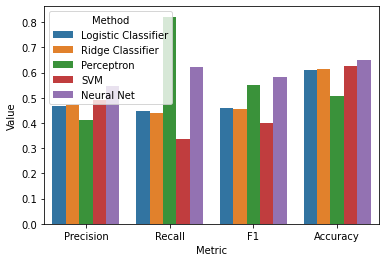

In [14]:
sns.barplot(data=viz_df[viz_df["Metric"] != "Duration"], x="Metric", y="Value", hue="Method")

<AxesSubplot:xlabel='Metric', ylabel='Value'>

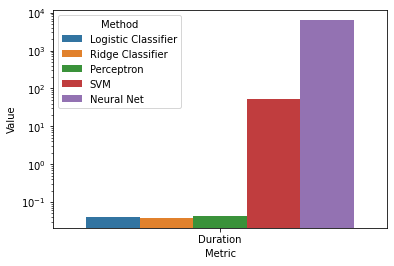

In [16]:
sns.barplot(data=viz_df[viz_df["Metric"] == "Duration"], x="Metric", y="Value", hue="Method", log=True)